In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk jupyter wordcloud

Note: you may need to restart the kernel to use updated packages.


In [9]:
# === STEP 1: INSTALL REQUIRED PACKAGES ===
# Run this cell first to install all necessary packages
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed and imported successfully!")

✅ All packages installed and imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# === STEP 2: LOAD AND EXPLORE DATASET ===
# Load your spam.csv dataset
data = pd.read_csv("spam.csv", encoding='latin1')

print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print("\nFirst 5 rows:")
display(data.head())

print("\n🔍 BASIC INFO")
print("=" * 50)
print("Data types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())
print("\nLabel distribution:")
print(data['type'].value_counts())

# Check for empty text
data['text_length'] = data['text'].apply(lambda x: len(str(x).strip()))
empty_text_count = (data['text_length'] == 0).sum()
print(f"\nEmpty text entries: {empty_text_count}")

📊 DATASET OVERVIEW
Dataset Shape: (84, 3)
Columns: ['title', 'text', 'type']

First 5 rows:


,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam



🔍 BASIC INFO
Data types:
title    object
text     object
type     object
dtype: object

Missing values:
title    0
text     0
type     0
dtype: int64

Label distribution:
type
not spam    58
spam        26
Name: count, dtype: int64

Empty text entries: 0


In [11]:
# === STEP 3: DATA CLEANING AND PREPROCESSING ===
print("🧹 CLEANING AND PREPROCESSING DATA")
print("=" * 50)

# Initialize text processing tools
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to string and handle missing values
    if not isinstance(text, str):
        text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Stemming
    tokens = [ps.stem(word) for word in tokens]
    
    return ' '.join(tokens)

# Combine title and text for better features
data['combined_text'] = data['title'] + ' ' + data['text']

# Clean the combined text
data['cleaned_text'] = data['combined_text'].apply(clean_text)

# Convert labels to binary (spam = 1, not spam = 0)
data['label'] = data['type'].apply(lambda x: 1 if str(x).strip().lower() == 'spam' else 0)

print("✅ Text cleaning completed!")
print(f"Sample cleaned text: {data['cleaned_text'].iloc[0][:100]}...")
print(f"Final label distribution: {data['label'].value_counts().to_dict()}")

🧹 CLEANING AND PREPROCESSING DATA
✅ Text cleaning completed!
Sample cleaned text: secret success jame claim complimentari gift yet ive compil special astrolog gift predict everyth fu...
Final label distribution: {0: 58, 1: 26}


📈 EXPLORATORY DATA ANALYSIS


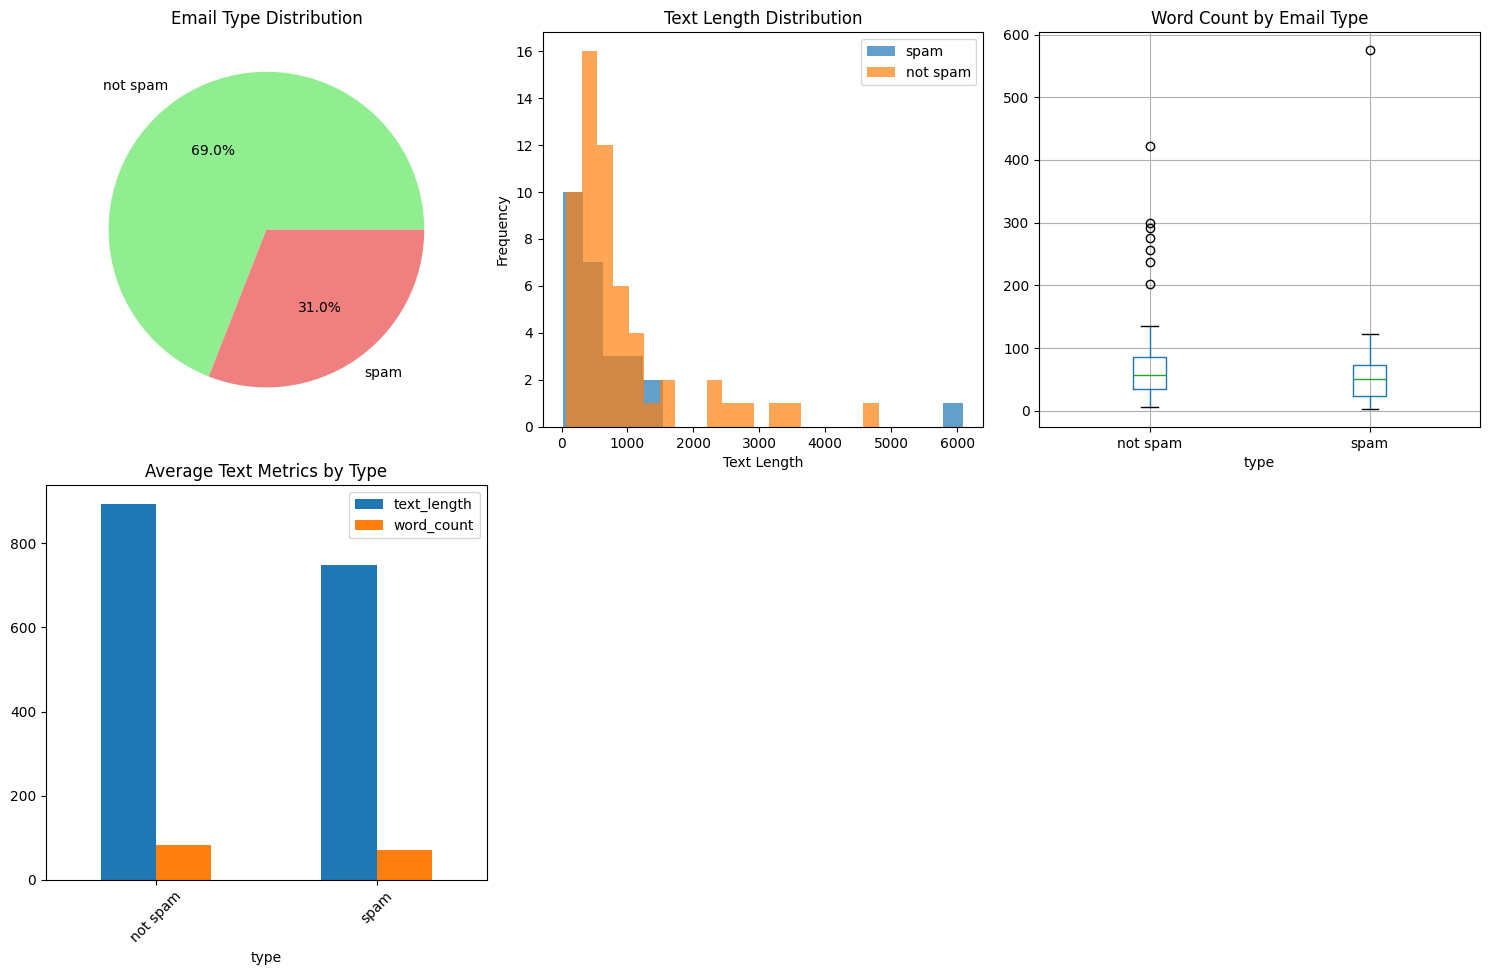


📊 STATISTICAL SUMMARY
Average text length by type:
type
not spam    893.810345
spam        748.461538
Name: text_length, dtype: float64

Average word count by type:
type
not spam    83.000000
spam        70.807692
Name: word_count, dtype: float64


In [12]:
# === STEP 4: EXPLORATORY DATA ANALYSIS ===
print("📈 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

plt.figure(figsize=(15, 10))

# Plot 1: Label distribution
plt.subplot(2, 3, 1)
data['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Email Type Distribution')
plt.ylabel('')

# Plot 2: Text length distribution
plt.subplot(2, 3, 2)
data['text_length'] = data['text'].apply(lambda x: len(str(x)))
for label_type in ['spam', 'not spam']:
    subset = data[data['type'] == label_type]
    plt.hist(subset['text_length'], alpha=0.7, label=label_type, bins=20)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Text Length Distribution')

# Plot 3: Word count by type
plt.subplot(2, 3, 3)
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data.boxplot(column='word_count', by='type', ax=plt.gca())
plt.title('Word Count by Email Type')
plt.suptitle('')  # Remove automatic title

# Plot 4: Average metrics
plt.subplot(2, 3, 4)
avg_metrics = data.groupby('type').agg({
    'text_length': 'mean',
    'word_count': 'mean'
})
avg_metrics.plot(kind='bar', ax=plt.gca())
plt.title('Average Text Metrics by Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 STATISTICAL SUMMARY")
print("=" * 50)
print("Average text length by type:")
print(data.groupby('type')['text_length'].mean())
print("\nAverage word count by type:")
print(data.groupby('type')['word_count'].mean())

In [13]:
# === STEP 5: FEATURE EXTRACTION ===
print("🔧 EXTRACTING FEATURES WITH TF-IDF")
print("=" * 50)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,      # Use top 1000 words
    stop_words='english',   # Remove English stopwords
    ngram_range=(1, 2)      # Use single words and 2-word combinations
)

# Transform text to numerical features
X = tfidf.fit_transform(data['cleaned_text'])
y = data['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")
print(f"Sample features: {tfidf.get_feature_names_out()[:10]}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,          # 30% for testing
    random_state=42,        # For reproducible results
    stratify=y              # Maintain class distribution
)

print(f"\n📁 DATA SPLIT SUMMARY")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training spam count: {y_train.sum()}")
print(f"Testing spam count: {y_test.sum()}")

🔧 EXTRACTING FEATURES WITH TF-IDF
Feature matrix shape: (84, 1000)
Number of features: 1000
Sample features: ['abil' 'abl' 'absorpt' 'academ' 'accept' 'accept incom' 'access'
 'access account' 'access new' 'account']

📁 DATA SPLIT SUMMARY
Training set: 58 samples
Testing set: 26 samples
Training spam count: 18
Testing spam count: 8


In [14]:
# === STEP 6: MODEL TRAINING ===
print("🤖 TRAINING MACHINE LEARNING MODELS")
print("=" * 50)

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Dictionary to store results
results = {}
trained_models = {}

print("Training progress:")
print("-" * 30)

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"✅ {name} trained - Accuracy: {accuracy:.4f}")

print("\n🎯 MODEL PERFORMANCE SUMMARY")
print("=" * 50)
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

🤖 TRAINING MACHINE LEARNING MODELS
Training progress:
------------------------------
Training Naive Bayes...
✅ Naive Bayes trained - Accuracy: 0.6923
Training Random Forest...
✅ Random Forest trained - Accuracy: 0.6538
Training SVM...
✅ SVM trained - Accuracy: 0.7692

🎯 MODEL PERFORMANCE SUMMARY
Naive Bayes: 0.6923
Random Forest: 0.6538
SVM: 0.7692


📊 EVALUATING MODEL PERFORMANCE
🏆 BEST MODEL: SVM
📈 Accuracy: 0.7692

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Not Spam       0.75      1.00      0.86        18
        Spam       1.00      0.25      0.40         8

    accuracy                           0.77        26
   macro avg       0.88      0.62      0.63        26
weighted avg       0.83      0.77      0.72        26



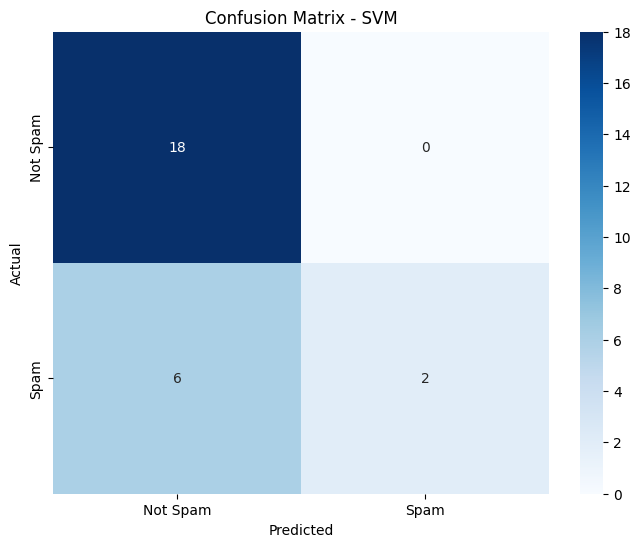

In [15]:
# === STEP 7: MODEL EVALUATION ===
print("📊 EVALUATING MODEL PERFORMANCE")
print("=" * 50)

# Find best model
best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"📈 Accuracy: {results[best_model_name]:.4f}")

# Detailed evaluation of best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print("\n📋 DETAILED CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
# === STEP 8: FEATURE IMPORTANCE ===
print("🔍 ANALYZING FEATURE IMPORTANCE")
print("=" * 50)

if hasattr(best_model, 'feature_importances_'):
    # For Random Forest
    importances = best_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()
    
    # Create feature importance dataframe
    feature_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Spam Indicators:")
    print(feature_df.head(10))
    
    # Plot top features
    plt.figure(figsize=(10, 6))
    top_features = feature_df.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features for Spam Detection')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_names = tfidf.get_feature_names_out()
    coefs = best_model.coef_[0]
    
    feature_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs
    }).sort_values('coefficient', ascending=False)
    
    print("Top 10 Spam Indicators:")
    print(feature_df.head(10))
    print("\nTop 10 Not Spam Indicators:")
    print(feature_df.tail(10))

🔍 ANALYZING FEATURE IMPORTANCE


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [17]:
# === STEP 9: TEST WITH CUSTOM EXAMPLES ===
print("🧪 TESTING WITH CUSTOM EMAILS")
print("=" * 50)

def predict_spam(email_text, model=best_model, vectorizer=tfidf):
    """
    Predict if an email is spam or not
    """
    # Clean the text
    cleaned_text = clean_text(email_text)
    
    # Transform using TF-IDF
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    result = "SPAM 🚨" if prediction == 1 else "NOT SPAM ✅"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    print(f"📧 Email: {email_text[:80]}...")
    print(f"🔍 Prediction: {result}")
    print(f"📊 Confidence: {confidence:.4f}")
    print(f"📈 Probabilities - Spam: {probability[1]:.4f}, Not Spam: {probability[0]:.4f}")
    print("-" * 60)
    
    return result

# Test examples
test_emails = [
    "Win a free iPhone now! Click here to claim your prize! Limited time offer!",
    "Hi John, can we schedule a meeting for tomorrow at 2 PM?",
    "URGENT: Your account will be suspended unless you verify now!",
    "Hello team, attached is the report for this week's progress.",
    "Get rich quick! Earn $5000 per week working from home!",
    "Your package has been delivered. Tracking number: 123456789."
]

print("Testing custom email examples:\n")
for i, email in enumerate(test_emails, 1):
    print(f"Example {i}:")
    predict_spam(email)
    print()

🧪 TESTING WITH CUSTOM EMAILS
Testing custom email examples:

Example 1:
📧 Email: Win a free iPhone now! Click here to claim your prize! Limited time offer!...
🔍 Prediction: SPAM 🚨
📊 Confidence: 1.0000
📈 Probabilities - Spam: 1.0000, Not Spam: 0.0000
------------------------------------------------------------

Example 2:
📧 Email: Hi John, can we schedule a meeting for tomorrow at 2 PM?...
🔍 Prediction: NOT SPAM ✅
📊 Confidence: 0.5093
📈 Probabilities - Spam: 0.4907, Not Spam: 0.5093
------------------------------------------------------------

Example 3:
📧 Email: URGENT: Your account will be suspended unless you verify now!...
🔍 Prediction: NOT SPAM ✅
📊 Confidence: 0.9577
📈 Probabilities - Spam: 0.0423, Not Spam: 0.9577
------------------------------------------------------------

Example 4:
📧 Email: Hello team, attached is the report for this week's progress....
🔍 Prediction: NOT SPAM ✅
📊 Confidence: 0.6616
📈 Probabilities - Spam: 0.3384, Not Spam: 0.6616
------------------------------

In [18]:
# === STEP 10: SAVE THE MODEL ===
print("💾 SAVING THE MODEL")
print("=" * 50)

import joblib

# Save model and vectorizer
model_data = {
    'model': best_model,
    'vectorizer': tfidf,
    'model_name': best_model_name
}

joblib.dump(model_data, 'spam_classifier.pkl')
print("✅ Model saved as 'spam_classifier.pkl'")

# Function to load model (for future use)
def load_spam_model():
    model_data = joblib.load('spam_classifier.pkl')
    return model_data['model'], model_data['vectorizer']

print("🎉 SPAM CLASSIFICATION MODEL TRAINING COMPLETED!")
print("You can now use this model to classify emails as spam or not spam.")

💾 SAVING THE MODEL
✅ Model saved as 'spam_classifier.pkl'
🎉 SPAM CLASSIFICATION MODEL TRAINING COMPLETED!
You can now use this model to classify emails as spam or not spam.
